## 2020/4/22の近況報告会を受けて

まずはARモデルで作成した人工時系列を用いて、**きちんとARモデルの係数が推定できているのか**を確認すべき。

$G_{\theta}$と$F_{\phi}$は活性化関数を直線にした一層のニューラルネットで！

## 2020/5/20の院ゼミより

とりあえず実装してみましょ

<img src="../../images/モデルの全体像.jpeg" alt="モデルの全体像" title="モデル全体像" width=70%>

In [1]:
%matplotlib inline
import argparse
import os
path = os.getcwd()
path=path[:path.find('timeseries-WGAN')+15]
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
import sys
sys.path.append(path+"/")
import random
import statsmodels.api as sm
from scipy.stats import norm


import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable

In [2]:
# 人工データを生成してくれる機械が置いてあるところ
import tsModel
# 学習用のニューラルネットが置いてあるところ
import models

In [3]:
# "output-images"フォルダを作成（既にあるならそれで良し）
os.makedirs("output-images", exist_ok=True)
os.makedirs("parameters", exist_ok=True)

In [4]:
# 学習時のハイパラの決定（入力を受け付ける）
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=20000, help="Discriminatorを学習させる回数")
parser.add_argument("--p", type=int, default=7, help="ARの次数(generatorへの入力の次元)")
parser.add_argument("--generator_seed", type=int, default=0, help="generatorのパラメータの初期値のシード")
parser.add_argument("--discriminator_seed", type=int, default=0, help="discriminatorのパラメータの初期値のシード")
parser.add_argument("--random_seed", type=int, default=0, help="訓練データの時系列のどの時刻を学習に用いるかをランダムに決定する時のシード")
parser.add_argument("--batch_size", type=int, default=64, help="batchの大きさ")
parser.add_argument("--discriminator_hidden_unit", type=int, default=64, help="discriminatorの隠れ層のニューロンの数")
parser.add_argument("--lr", type=float, default=0.00005, help="学習率")
parser.add_argument("--n_critic", type=int, default=5, help="一度generatorをbackpropするごとに何回discriminatorをbackpropするか")
parser.add_argument("--sample_interval", type=int, default=1000, help="batchを何回学習させる度にgeneratorの出力を保存するか")
parser.add_argument("--withGP", type=bool, default=False, help="clipingの代わりにGradient Penaltyを加えるかどうか。True/False")
parser.add_argument("--withCorr", type=bool, default=False, help="Generatorの出力がbatch方向に無相関になるようなロスを加えるかどうか。　True/False")
parser.add_argument("--data_seed", type=int, default=0, help="Dataの作成に用いる乱数のseed")
# opt = parser.parse_args()
opt = parser.parse_args(args=[])

opt.n_epochs=100
opt.sample_interval=10
opt.withGP=True
opt.withCorr = True

print(opt)

if not opt.withGP:
    clip_value = input('discriminatorのパラメータをclipする値(正の数)を入力してください(defaultは0.01)：')
    try:
        clip_value=float(clip_value)
        if clip_value<=0:
            clip_value=0.01
    except:
        clip_value=0.01
    print("clip値は",clip_value,"です。")


# 相関係数の制約をLossに加える際の重みの設定
default_weight = 1
if opt.withCorr:
    corr_weight= input("相関係数の制約をLossに加える時の重みを入力してください。(defaultは{0})：".format(default_weight))
    try:
        corr_weight = float(corr_weight)
        if corr_weight<0:
            corr_weight = default_weight
    except:
        corr_weight=default_weight
    print("相関係数に関する制約のLoss内での重みは{0}です。".format(corr_weight))
        
else:
    corr_weight=0


Namespace(batch_size=64, data_seed=0, discriminator_hidden_unit=64, discriminator_seed=0, generator_seed=0, lr=5e-05, n_critic=5, n_epochs=100, p=7, random_seed=0, sample_interval=10, withCorr=True, withGP=True)
相関係数の制約をLossに加える時の重みを入力してください。(defaultは1)：1
相関係数に関する制約のLoss内での重みは1.0です。


In [5]:
# gpuが使えるかどうか
cuda = True if torch.cuda.is_available() else False
if cuda:
    print("GPUが使えます。")
    use_gpu = input('GPUを使いますか？ （Yes：1, No：0）  ----> ')
    cuda = bool(int(use_gpu))
else:
    print("GPUは使えません。")
    
if cuda:
    gpu_id = input('使用するGPUの番号を入れてください : ')
    os.environ["CUDA_VISIBLE_DEVICES"] = gpu_id
device = torch.device('cuda:'+gpu_id if cuda else 'cpu')

GPUが使えます。
GPUを使いますか？ （Yes：1, No：0）  ----> 1
使用するGPUの番号を入れてください : 1


In [6]:
torch.manual_seed(opt.generator_seed)
generator = models.LinearGenerator(p = opt.p, input_dim=1, is_bias=False)
# generator = models.Generator(p=opt.p)

In [7]:
a= torch.rand([opt.batch_size,1, opt.p+1])
print("input size   :",a.shape)
b = generator(a)
print("output size:",b.shape)

input size   : torch.Size([64, 1, 8])
output size: torch.Size([64, 1])


In [8]:
torch.manual_seed(opt.discriminator_seed)
discriminator = models.Discriminator(q=0, discriminator_hidden_unit=opt.discriminator_hidden_unit)

In [9]:
a= torch.rand([opt.batch_size, 1])
print("input size   :",a.shape)
b = discriminator(a)
print("output size:",b.shape)

input size   : torch.Size([64, 1])
output size: torch.Size([64, 1])


### 人工データの作成

正規乱数


/home/lab/ryuichi/.pyenv/versions/anaconda3-4.3.1/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


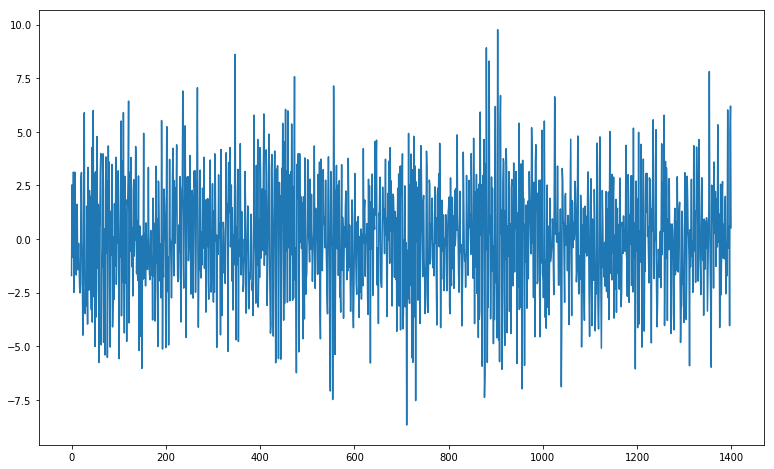

In [10]:
# 人工データの作成
Data = tsModel.SARIMA(a=[0.3,-0.4,0.2,-0.5,0.6,-0.1,0.1], N=1400, random_seed=opt.data_seed, sigma=2)
Data = torch.tensor(Data, dtype=torch.float)
Data = torch.tensor(Data)
plt.figure(figsize=(13,8))
plt.plot(Data)
plt.savefig(path+"/images/AR7モデルの人工データその{0}.png".format(opt.data_seed))
plt.show()
plt.close()

In [11]:
Data=Data.view(1,-1)

In [12]:
trainData = Data[:,:1000]
valData = Data[:,1000:1200]
testData = Data[:,1200:]

In [13]:
trainMatrix = []
for i in range(trainData.shape[1]-(opt.p+1)):
    ans = trainData[:,i:i+opt.p+1].view(1,Data.shape[0],-1)
    trainMatrix.append(ans)
trainMatrix = torch.cat(trainMatrix)
trainMatrix.shape

torch.Size([992, 1, 8])

In [14]:
valMatrix = []
for i in range(valData.shape[1]-(opt.p+1)):
    ans = valData[:,i:i+opt.p+1].view(1,Data.shape[0],-1)
    valMatrix.append(ans)
valMatrix = torch.cat(valMatrix)
valMatrix.shape

torch.Size([192, 1, 8])

## 学習

In [15]:
# Optimizers(パラメータに対して定義される)
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=opt.lr)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=opt.lr)

In [16]:
# パラメータと学習データをGPUに乗っける
generator.to(device)
discriminator.to(device)

trainMatrix=trainMatrix.to(device)
valMatrix=valMatrix.to(device)

In [17]:
def gradient_penalty(generated_data, real_data, gp_weight=10):

    batch_size = real_data.size()[0]

    alpha = torch.rand(batch_size, 1)
    alpha = alpha.expand_as(real_data)
    if cuda:
        alpha=alpha.to(device)

    interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
    interpolated = Variable(interpolated, requires_grad=True)
    if cuda:
        interpolated=interpolated.to(device)

    # Calculate probability of interpolated examples
    prob_interpolated = discriminator(interpolated)

    gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).to(device) if cuda else torch.ones(
                               prob_interpolated.size()),
                               create_graph=True, retain_graph=True)[0]

    gradients = gradients.view(batch_size, -1)# これいらないかも...
    
    # gradients_norm = (gradients.norm(2, dim=1) - 1) ** 2
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)# 0除算を防ぐ？

    return gp_weight * ((gradients_norm - 1) ** 2).mean()

In [18]:
saveModel = input('作成したモデルを保存しますか？ （Yes：1, No：0）  ----> ')
saveModel = bool(int(saveModel))

作成したモデルを保存しますか？ （Yes：1, No：0）  ----> 1


In [19]:
import japanize_matplotlib
from scipy.stats import gaussian_kde

In [20]:
def corr(x):
    return (((x-x.mean())*(x-x.mean()).T)*(1-torch.eye(x.shape[0],x.shape[0]).to(device))).sum()/2/x.shape[0]

In [21]:
batches_done = 0
generator_done = 0# generatorを学習した回数

# グラフ描画用
loss_D_curve = []
loss_G_curve = []
val_loss_D_curve = []
val_loss_G_curve = []
p_value = []

# 訓練データの時系列のどの時刻を学習に用いるかをランダムにしているが、そのランダムシードを固定する
random.seed(a=opt.random_seed)

for epoch in range(1, opt.n_epochs+1):# epochごとの処理
    
    # trainMatrixの行をランダムにシャッフルする
    # r=torch.randperm(trainMatrix.shape[0])
    # c=torch.arange(trainMatrix.shape[1])
    # trainMatrix = trainMatrix[r[:, None],c]
    
    for i, batch in enumerate(range(0, trainMatrix.shape[0]-opt.batch_size, opt.batch_size)):# batchごとの処理
        
        # generatorへの入力を用意する
        X = trainMatrix[batch:batch+opt.batch_size]# torch.Size([64, 1, 8])
        # 時系列の順番はそのまま入力した方がいいのかな？
        rand=random.randint(0,trainMatrix.shape[0] - trainMatrix.shape[0]// opt.batch_size*opt.batch_size)
        X = trainMatrix[batch+rand : batch+rand+opt.batch_size]# torch.Size([64, 1, 8])
    
        X = Variable(X)# 自動微分？
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        for p in discriminator.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update

        if not opt.withGP:
            # discriminatorのパラメタをクリップする（全てのパラメタの絶対値がclip_value以下の値になる）
            for idx, p in enumerate(discriminator.parameters()):
                if idx==0:
                    continue #  sigmaはクリップしない
                p.data.clamp_(-clip_value, clip_value)

        
        # 勾配情報を0に初期化する
        optimizer_D.zero_grad()        
        
        # 現在＋過去p時刻分の時系列をgeneratorで変換した値を取得
        hat_epsilon = generator(X)#.detach() # torch.Size([64, 4])
        # この「.detach()」はTensor型から勾配情報を抜いたものを取得する.(つまりこの後の誤差逆伝播のところではgeneratorのパラメタまで伝播しない)
        
        # generatorの出力と同じ大きさの標準正規分布からのサンプルを作成
        epsillon = Variable(torch.randn_like(hat_epsilon))
        
        # Adversarial loss すなわちWasserstein距離の符号を反転させたもの。（DiscriminatorはWasserstein距離を最大にする関数になりたい）
        if opt.withGP:
            loss_D = -torch.mean(discriminator(epsillon, is_from_generator=False)) + torch.mean(discriminator(hat_epsilon, is_from_generator=True)) + gradient_penalty(generated_data=hat_epsilon, real_data=epsillon, gp_weight=10)
        else:
            loss_D = -torch.mean(discriminator(epsillon, is_from_generator=False)) + torch.mean(discriminator(hat_epsilon, is_from_generator=True))
 

        # loss_Dを目的関数として微分をしてくれと言う合図
        loss_D.backward()
        # otimizerにしたがってパラメタを更新
        optimizer_D.step()

            
        # discriminatorをopt.n_critic回学習させるごとに一回generatorを学習させる(ただし最初はめっちゃdiscriminatorを優先させる)
        if batches_done % (100 if generator_done<25 or generator_done%500==0 else opt.n_critic) == 0:
            
            # -----------------
            #  Train Generator
            # -----------------
            
            for p in discriminator.parameters():
                p.requires_grad = False # to avoid computation
            
            # generatorの勾配情報を0に初期化
            optimizer_G.zero_grad()
            
            # 現在＋過去p時刻分の時系列をgeneratorで変換した値を取得
            hat_epsilon = generator(X)# torch.Size([64, 4]) (今度はdetachしない)
            
            # Adversarial loss(discriminatorの出力の期待値を大きくして、つまりWasserstein距離の第二項を大きくして、Wasserstein距離小さくしたい)
            # ここに相関係数を小さくするロスも加える？
            if opt.withCorr:
                loss_G = -torch.mean(discriminator(hat_epsilon, is_from_generator=True)) + corr_weight*corr(hat_epsilon)
            else:
                loss_G = -torch.mean(discriminator(hat_epsilon, is_from_generator=True))
            
            # loss_Gを目的関数として微分をしてくれと言う合図
            loss_G.backward()
            optimizer_G.step()
            
            generator_done+=1

            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, opt.n_epochs, batches_done % trainMatrix.shape[0]//opt.batch_size, trainMatrix.shape[0]//opt.batch_size, loss_D.item(), loss_G.item()) )
            
        
        if batches_done % opt.sample_interval == 0:
            # もしここでhat_epsilon保存するなら保存する
            # hat_epsilon[:,0].shape
            # a=hat_epsilon
            # a=a.cpu().detach().numpy()
            # plt.hist(a[:,0])
            # plt.close()
            pass
        
        batches_done += 1

    loss_D_curve.append(loss_D.item())
    loss_G_curve.append(loss_G.item())

    #　validtation lossも付け加えたい
    val_hat_eps = generator(valMatrix)
    val_eps = torch.randn_like(val_hat_eps)
    if opt.withGP:
        val_loss_D = -torch.mean(discriminator(val_eps, is_from_generator=False)) + torch.mean(discriminator(val_hat_eps, is_from_generator=True)) 
        + gradient_penalty(generated_data=val_hat_eps, real_data=val_eps, gp_weight=1)
    else:
        val_loss_D = -torch.mean(discriminator(val_eps, is_from_generator=False)) + torch.mean(discriminator(val_hat_eps, is_from_generator=True))
    val_loss_D_curve.append(val_loss_D.item())
    if opt.withCorr:
        val_loss_G  = -torch.mean(discriminator(val_hat_eps, is_from_generator=True)) + corr_weight*corr(val_hat_eps)
    else:
        val_loss_G = -torch.mean(discriminator(val_hat_eps, is_from_generator=True))
    val_loss_G_curve.append(val_loss_G.item())
    
    # validationデータでgeneratorの出力の正規性検定のp-値と相互相関係数を確認する
    rnd = random.randint(0, valMatrix.shape[0]-64)
    valX = valMatrix[rnd:rnd+64]
    val_hat_epsilon = generator(valX)
    # p-値
    a=val_hat_epsilon[:,0].cpu().detach().numpy()
    p_value.append(stats.shapiro(a)[1])


    if saveModel:
        if epoch%opt.sample_interval==0 or epoch==opt.n_epochs:
            torch.save(generator.state_dict(), 'parameters/generator_epoch{0}_{1}_batchSize{2}_randomSeed{3}_p{4}_gSeed{5}_dSeed{6}_dHiddenUnit{7}-withGP{8}_withCorr{9}.pth'
                       .format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.generator_seed, opt.discriminator_seed, opt.discriminator_hidden_unit, str(opt.withGP), str(opt.withCorr)))
            torch.save(discriminator.state_dict(), 'parameters/discriminator_epoch{0}_{1}_batchSize{2}_randomSeed{3}_p{4}_gSeed{5}_dSeed{6}_dHiddenUnit{7}-withGP{8}_withCorr{9}.pth'
                       .format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.generator_seed, opt.discriminator_seed, opt.discriminator_hidden_unit, str(opt.withGP), str(opt.withCorr)))

        if epoch%opt.sample_interval==0 or epoch==opt.n_epochs:
            kde = gaussian_kde(a)
            ls = np.linspace(min(a)-np.var(a), max(a)+np.var(a) , 100)
            plt.figure(figsize=(13,8))
            plt.title("generatorの出力の分布　\n　epoch:{0}/{1}, batchSize:{2}, randomSeed:{3}, p:{4}, gSeed:{5}, dSeed:{6}, dHiddenUnit:{7}, withGP:{8}, withCorr:{9}"
                      .format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.generator_seed, opt.discriminator_seed, opt.discriminator_hidden_unit, str(opt.withGP), str(opt.withCorr))+"\n p-値："+str(stats.shapiro(a)[1]))
            plt.ylabel("密度")
            plt.plot(ls, kde.pdf(ls) , label="$\hat\epsilon$")
            plt.plot(ls, norm.pdf(ls), label="$\mathcal{N}(0,1)$")
            plt.legend()
            plt.savefig("output-images/density_epoch{0}_{1}_batchSize{2}_randomSeed{3}_p{4}_gSeed{5}_dSeed{6}_dHiddenUnit{7}-withGP{8}_withCorr{9}.png"
                        .format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.generator_seed, opt.discriminator_seed, opt.discriminator_hidden_unit, str(opt.withGP), str(opt.withCorr)))
            plt.close()

    if epoch%opt.sample_interval==0 or epoch==opt.n_epochs:
        plt.figure(figsize=(13,8))
        plt.title("DiscriminatorのLossの遷移　\n　epoch:{1}, batchSize:{2}, randomSeed:{3}, p:{4}, gSeed:{5}, dSeed:{6}, dHiddenUnit:{7}, withGP:{8}, withCorr:{9}"
                  .format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.generator_seed, opt.discriminator_seed, opt.discriminator_hidden_unit, str(opt.withGP), str(opt.withCorr)))
        plt.xlabel("epoch")
        plt.ylabel("Loss")
        plt.plot(loss_D_curve, label="training")
        plt.plot(val_loss_D_curve, label="validation")
        plt.legend()
        plt.savefig("loss.png")
        plt.close()

torch.save(generator.state_dict(), 'parameters/generator_epoch{1}_batchSize{2}_randomSeed{3}_p{4}_gSeed{5}_dSeed{6}_dHiddenUnit{7}-withGP{8}_withCorr{9}.pth'
           .format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.generator_seed, opt.discriminator_seed, opt.discriminator_hidden_unit, str(opt.withGP), str(opt.withCorr)))
torch.save(discriminator.state_dict(), 'parameters/discriminator_epoch{1}_batchSize{2}_randomSeed{3}_p{4}_gSeed{5}_dSeed{6}_dHiddenUnit{7}-withGP{8}_withCorr{9}.pth'
           .format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.generator_seed, opt.discriminator_seed, opt.discriminator_hidden_unit, str(opt.withGP), str(opt.withCorr)))



[Epoch 1/100] [Batch 0/15] [D loss: 9.781439] [G loss: -0.616331]
[Epoch 7/100] [Batch 1/15] [D loss: 5.537868] [G loss: -0.756156]
[Epoch 14/100] [Batch 3/15] [D loss: 2.822483] [G loss: -0.604446]
[Epoch 21/100] [Batch 4/15] [D loss: 1.137733] [G loss: -0.652648]
[Epoch 27/100] [Batch 6/15] [D loss: 0.401127] [G loss: -0.598014]
[Epoch 34/100] [Batch 7/15] [D loss: 0.271050] [G loss: -0.626705]
[Epoch 41/100] [Batch 9/15] [D loss: 0.118643] [G loss: -0.639830]
[Epoch 47/100] [Batch 10/15] [D loss: 0.023636] [G loss: -0.682636]
[Epoch 54/100] [Batch 12/15] [D loss: 0.068802] [G loss: -0.741450]
[Epoch 61/100] [Batch 14/15] [D loss: 0.070694] [G loss: -0.762029]
[Epoch 67/100] [Batch 0/15] [D loss: 0.197562] [G loss: -0.795034]
[Epoch 74/100] [Batch 1/15] [D loss: 0.077047] [G loss: -0.813884]
[Epoch 81/100] [Batch 3/15] [D loss: 0.079497] [G loss: -0.779351]
[Epoch 87/100] [Batch 4/15] [D loss: 0.079787] [G loss: -0.923304]
[Epoch 94/100] [Batch 6/15] [D loss: 0.073622] [G loss: -0.94

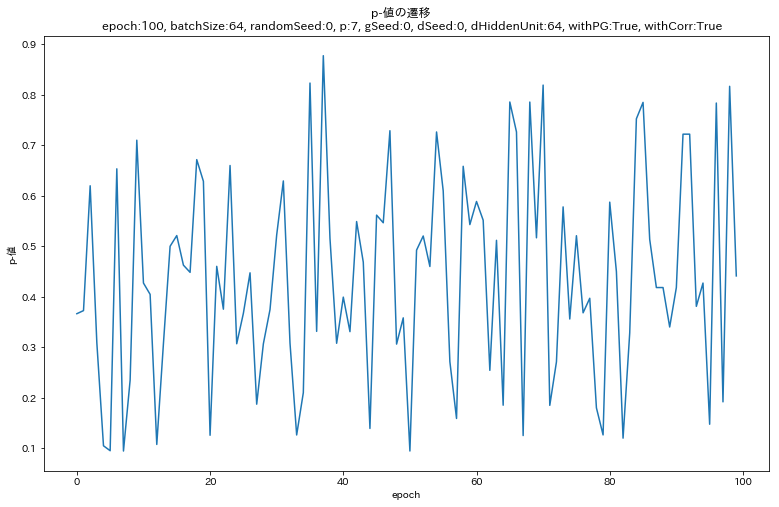

In [22]:
# 結果の保存
# p-値
plt.figure(figsize=(13,8))
plt.plot(p_value)
plt.title("p-値の遷移　\n　epoch:{1}, batchSize:{2}, randomSeed:{3}, p:{4}, gSeed:{5}, dSeed:{6}, dHiddenUnit:{7}, withPG:{8}, withCorr:{9}".format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.generator_seed, opt.discriminator_seed, opt.discriminator_hidden_unit, str(opt.withGP), str(opt.withCorr)))
plt.xlabel("epoch")
plt.ylabel("p-値")
plt.savefig("output-images/p-value_epoch{1}_batchSize{2}_randomSeed{3}_p{4}_gSeed{5}_dSeed{6}_dHiddenUnit{7}_withGP{8}_withCorr{9}.png".format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.generator_seed, opt.discriminator_seed,opt.discriminator_hidden_unit, str(opt.withGP), str(opt.withCorr)))
# plt.close()

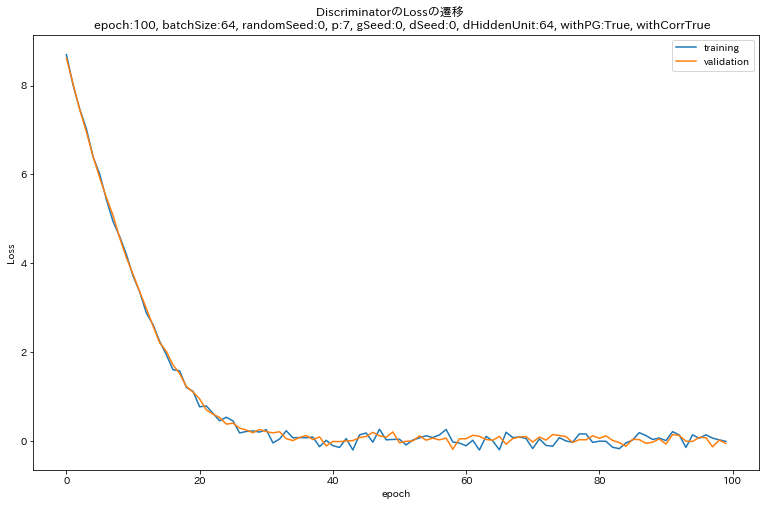

In [23]:
# discriminatorのLoss
plt.figure(figsize=(13,8))
plt.title("DiscriminatorのLossの遷移　\n　epoch:{1}, batchSize:{2}, randomSeed:{3}, p:{4}, gSeed:{5}, dSeed:{6}, dHiddenUnit:{7}, withPG:{8}, withCorr{9}".format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.generator_seed, opt.discriminator_seed, opt.discriminator_hidden_unit, str(opt.withGP), str(opt.withCorr)))
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(loss_D_curve, label="training")
plt.plot(val_loss_D_curve, label="validation")
plt.legend()
plt.savefig("output-images/loss-D-curve_epoch{1}_batchSize{2}_randomSeed{3}_p{4}_gSeed{5}_dSeed{6}_dHiddenUnit{7}_withGP{8}_withCorr{9}.png".format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.generator_seed, opt.discriminator_seed, opt.discriminator_hidden_unit, str(opt.withGP), str(opt.withCorr)))
# plt.close()

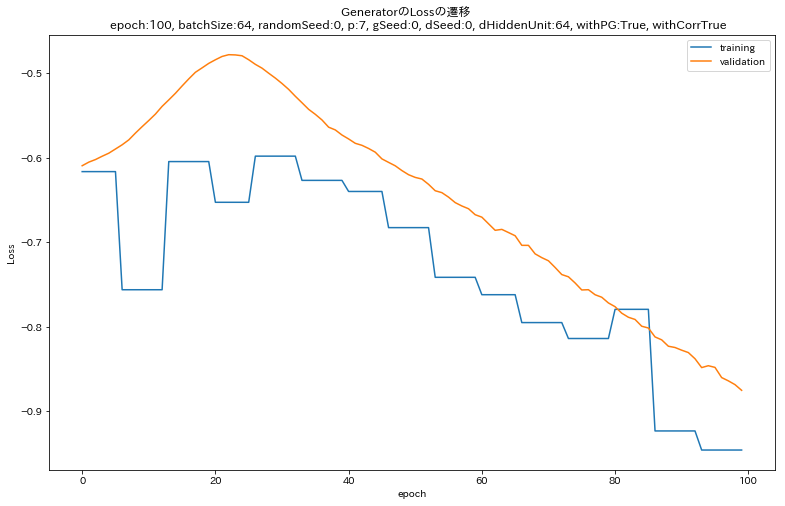

In [24]:
# genetaratorのLoss
plt.figure(figsize=(13,8))
plt.title("GeneratorのLossの遷移　\n　epoch:{1}, batchSize:{2}, randomSeed:{3}, p:{4}, gSeed:{5}, dSeed:{6}, dHiddenUnit:{7}, withPG:{8}, withCorr{9}".format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.generator_seed, opt.discriminator_seed, opt.discriminator_hidden_unit, str(opt.withGP), str(opt.withCorr)))
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(loss_G_curve, label="training")
plt.plot(val_loss_G_curve, label="validation")
plt.legend()
plt.savefig("output-images/loss-G-curve_epoch{1}_batchSize{2}_randomSeed{3}_p{4}_gSeed{5}_dSeed{6}_dHiddenUnit{7}_withGP{8}_whithCorr{9}.png".format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.generator_seed, opt.discriminator_seed, opt.discriminator_hidden_unit, str(opt.withGP), str(opt.withCorr)))
# plt.close()

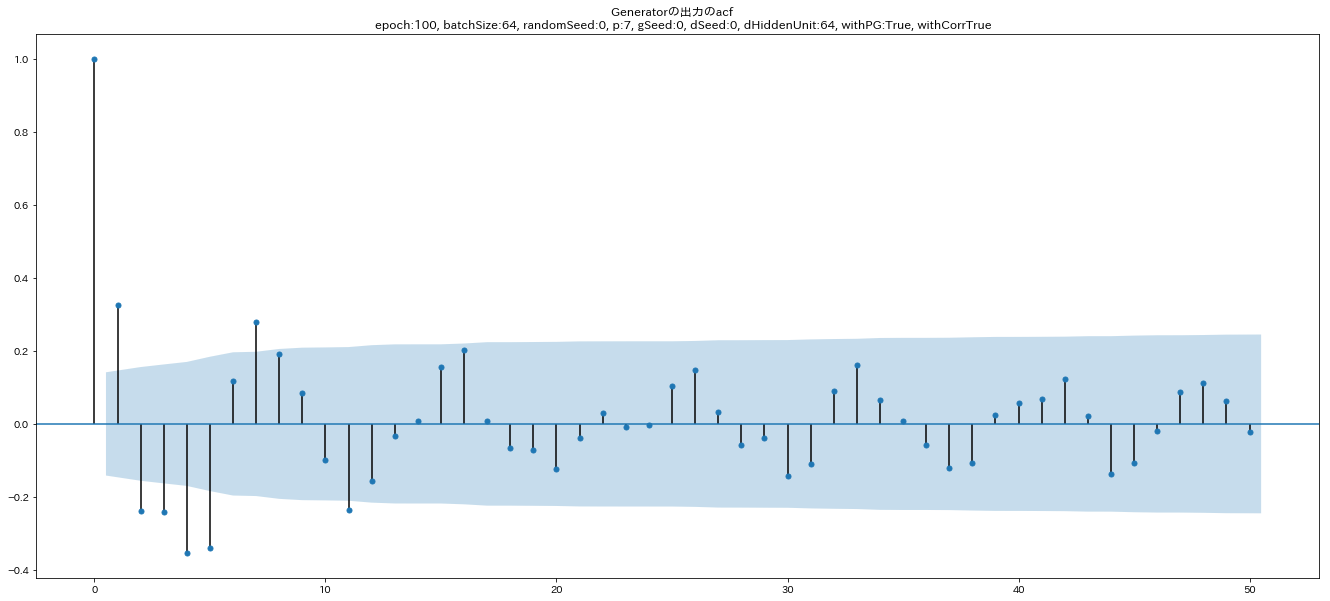

In [25]:
fig = plt.figure(figsize=(23,10))
ax1 = fig.add_subplot(111)
sm.graphics.tsa.plot_acf(generator(valMatrix).view(-1).detach().cpu().numpy(), lags=50, ax=ax1)
plt.title("Generatorの出力のacf　\n　epoch:{1}, batchSize:{2}, randomSeed:{3}, p:{4}, gSeed:{5}, dSeed:{6}, dHiddenUnit:{7}, withPG:{8}, withCorr{9}".format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.generator_seed, opt.discriminator_seed, opt.discriminator_hidden_unit, str(opt.withGP), str(opt.withCorr)))
plt.savefig("output-images/acf_epoch{1}_batchSize{2}_randomSeed{3}_p{4}_gSeed{5}_dSeed{6}_dHiddenUnit{7}_withGP{8}_withCorr{9}.png".format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.generator_seed, opt.discriminator_seed, opt.discriminator_hidden_unit, str(opt.withGP), str(opt.withCorr)))
# plt.close()

In [26]:
aaaa

NameError: name 'aaaa' is not defined

In [ ]:
hat_epsilon

In [ ]:
x=hat_epsilon

In [ ]:
x.cov

In [ ]:
loss_G+corr(hat_epsilon)

In [ ]:
torch.mean(x,)

In [ ]:
corr(hat_epsilon)

In [ ]:
x

In [ ]:
torch.eye(x.shape[0],x.shape[0]).shape

In [ ]:
(((x-x.mean())*(x-x.mean()).T)*(1-torch.eye(x.shape[0],x.shape[0]).to(device))).sum()/2/x.shape[0]